## Finetuned Fast Downsampling Mobilenet with self-attention

The model has much fewer blocks compared to the original mobile net with 2 **Multi Headed Attention** layers.

In [2]:
import tensorflow as tf

from tensorflow.keras import layers, models, applications




import tensorflow as tf

from tensorflow.keras import datasets

from tensorflow.keras.utils import to_categorical


def depthwise_separable_conv_block(inputs, filters, strides=1):
    x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # pointwise convolution layer
    x = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def self_attention(inputs):
    # using multi headed attention
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    return attention

def FD_MobileNet_with_attention(input_shape=(64, 64, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    #1st block
    x = depthwise_separable_conv_block(x, filters=64, strides=1)
    #2nd block
    x = depthwise_separable_conv_block(x, filters=128, strides=2)
    #3rd block
    x = depthwise_separable_conv_block(x, filters=128, strides=1)
    x = self_attention(x)
    #4th block
    x = depthwise_separable_conv_block(x, filters=256, strides=2)
    x = self_attention(x)
    #5th block
    x = depthwise_separable_conv_block(x, filters=256, strides=1)


    # Final Classification Layer
    distillation_feature = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(distillation_feature)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name='FD_MobileNet_with_attention')
    return model


#training the model
fd_mobilenet_with_attention = FD_MobileNet_with_attention(input_shape=(64, 64, 3), num_classes=10)
fd_mobilenet_with_attention.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fd_mobilenet_with_attention.summary()


Model: "FD_MobileNet_with_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 32, 32,    │        320 │ re_lu[0][0]       │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,112 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 16, 16,    │        640 │ re_lu_2[0][0]     │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │      8,320 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 16, 16,    │      1,280 │ re_lu_4[0][0]   

 Total params: 567,946 (2.17 MB)

 Trainable params: 565,002 (2.16 MB)

 Non-trainable params: 2,944 (11.50 KB)

## Training the model on cifar-10 dataset

In [7]:
# Load and preprocess the CIFAR-10 dataset

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

num_classes = 10




x_train = tf.image.resize(x_train, (64, 64))

x_test = tf.image.resize(x_test, (64, 64))




x_train = tf.cast(x_train, tf.float32) / 255.0

x_test = tf.cast(x_test, tf.float32) / 255.0

# One-hot encode the labels

y_train = to_categorical(y_train, num_classes)

y_test = to_categorical(y_test, num_classes)


fd_mobilenet_with_attention = FD_MobileNet_with_attention(input_shape=(64, 64, 3), num_classes=num_classes)


fd_mobilenet_with_attention.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = fd_mobilenet_with_attention.fit(

    x_train, y_train,

    validation_data=(x_test, y_test),

    batch_size=16,

    epochs=50,

    verbose=1

)

test_loss, test_accuracy = fd_mobilenet_with_attention.evaluate(x_test, y_test)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.3287 - loss: 1.7895 - val_accuracy: 0.4264 - val_loss: 1.6104
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.5257 - loss: 1.3039 - val_accuracy: 0.4370 - val_loss: 1.6805
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.5940 - loss: 1.1387 - val_accuracy: 0.6071 - val_loss: 1.0869
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.6376 - loss: 1.0259 - val_accuracy: 0.6429 - val_loss: 1.0025
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.6634 - loss: 0.9439 - val_accuracy: 0.5983 - val_loss: 1.1542
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.6879 - loss: 0.8728 - val_accuracy: 0.6607 - val_loss: 0.9362
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.7121 - loss: 0.8121 - val_accuracy: 0.6956 - val_loss: 0.8733
Epoch 8/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.7269 -

## Confusion Matrix
Generates the confusion matrix.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


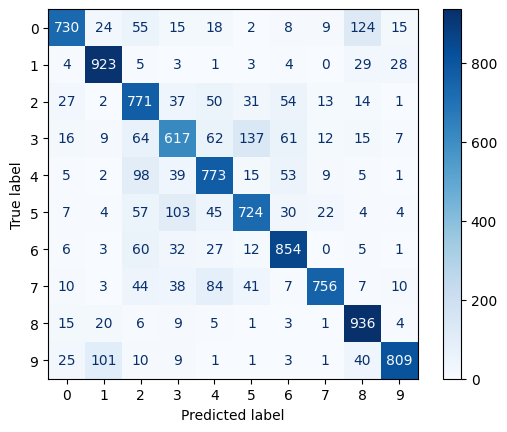

Confusion Matrix:
 [[730  24  55  15  18   2   8   9 124  15]
 [  4 923   5   3   1   3   4   0  29  28]
 [ 27   2 771  37  50  31  54  13  14   1]
 [ 16   9  64 617  62 137  61  12  15   7]
 [  5   2  98  39 773  15  53   9   5   1]
 [  7   4  57 103  45 724  30  22   4   4]
 [  6   3  60  32  27  12 854   0   5   1]
 [ 10   3  44  38  84  41   7 756   7  10]
 [ 15  20   6   9   5   1   3   1 936   4]
 [ 25 101  10   9   1   1   3   1  40 809]]


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = fd_mobilenet_with_attention.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)  

true_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test  # Handle one-hot encoding

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Confusion Matrix:\n", cm)


## Saved the model

In [10]:
fd_mobilenet_with_attention.save("fd_mobilenet_model.h5")


In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# download the dataset and put the path here.
dataset_folder = '/kaggle/input/trashnet'


train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(dataset_folder, 'train')
test_dir = os.path.join(dataset_folder, 'valid')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  
    batch_size=32,  
    class_mode='categorical',  
    subset="training"  
)

# Load images for validation=
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  
    batch_size=32,  
    class_mode='categorical',  
    subset="validation"  
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 981 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 162 images belonging to 3 classes.


## finetuning 
unfreezing more layers

In [17]:
# fd_mobilenet = tf.keras.models.load_model("fd_mobilenet_model.h5")
fd_mobilenet = tf.keras.models.load_model("/kaggle/input/model-path/fd_mobilenet_model.h5")
# for layer in fd_mobilenet.layers[:-10]:
#     layer.trainable = False
# fd_mobilenet.summary()

In [18]:
x = fd_mobilenet.layers[-3].output  # Second to last layer
x = tf.keras.layers.Dense(512, activation='relu')(x)  # New dense layer
x = tf.keras.layers.Dense(3, activation='softmax')(x)  # number of layers are 3


fine_tuned_model = tf.keras.Model(inputs=fd_mobilenet.input, outputs=x)
from tensorflow.keras.layers import MultiHeadAttention

# Freeze only the MultiHeadAttention layers
for layer in fine_tuned_model.layers:
    # attention layers are frozen.
    if isinstance(layer, MultiHeadAttention):  
        layer.trainable = False
    else:
        layer.trainable = True  
fine_tuned_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_10 │ (None, 32, 32,    │        320 │ re_lu_22[0][0]    │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │      2,112 │ re_lu_23[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_11 │ (None, 16, 16,    │        640 │ re_lu_24[0][0]    │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │      8,320 │ re_lu_25[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_12 │ (None, 16, 16,    │      1,280 │ re_lu_26[0][0]  

 Total params: 666,883 (2.54 MB)

 Trainable params: 268,803 (1.03 MB)

 Non-trainable params: 398,080 (1.52 MB)

In [19]:
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [20]:
dummy_input = tf.random.normal([1, 64, 64, 3])  # Example input size for MobileNet
fine_tuned_model(dummy_input)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.16688313, 0.27125475, 0.5618621 ]], dtype=float32)>

In [21]:
fine_tuned_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)


Epoch 1/20


I0000 00:00:1731688912.943207    1951 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_41', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1731688921.449508    1950 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 932 bytes spill stores, 932 bytes spill loads

I0000 00:00:1731688922.141781    1948 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_20', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1731688925.195057    1951 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1731688931.120145    1950 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 932 bytes spill stores, 932 bytes spill loads



21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4001 - loss: 1.0648

I0000 00:00:1731688949.277427    2055 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_20', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1731688953.734275    2057 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1731688962.449150    2055 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 932 bytes spill stores, 932 bytes spill loads

I0000 00:00:1731688964.429338    2054 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 932 bytes spill stores, 932 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4546 - loss: 1.0215 - val_accuracy: 0.5062 - val_loss: 1.1739
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7908 - loss: 0.5401 - val_accuracy: 0.5185 - val_loss: 1.3960
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.8454 - loss: 0.4028 - val_accuracy: 0.5514 - val_loss: 1.2253
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8673 - loss: 0.3157 - val_accuracy: 0.5597 - val_loss: 1.4510
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9219 - loss: 0.2056 - val_accuracy: 0.5926 - val_loss: 1.4877
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9530 - loss: 0.1381 - val_accuracy: 0.5802 - val_loss: 1.5709
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9669 - loss: 0.0974 - val_accuracy: 0.5967 - val_loss: 1.9176
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9843 - loss: 0.0578 - val_accuracy: 0.5844 - val_loss: 2.0

In [22]:
test_loss, test_accuracy = fine_tuned_model.evaluate(test_generator)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
fine_tuned_model.save("fd_mobilenet_model_f.h5")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.7128 - loss: 1.1936
Test loss: 1.0317392349243164, Test accuracy: 0.7592592835426331


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step


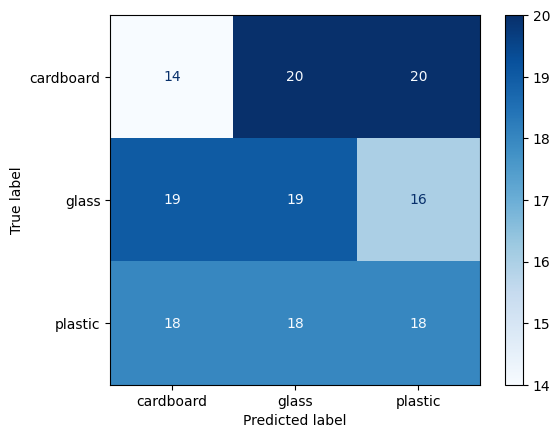

Confusion Matrix:
 [[14 20 20]
 [19 19 16]
 [18 18 18]]


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = fine_tuned_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  

true_classes = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())  

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Optional: Print confusion matrix
print("Confusion Matrix:\n", cm)
